## NCAAW March ML Mania

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.linear_model import LogisticRegression, LinearRegression

plt.style.use('fivethirtyeight')

## Utility Scripts
sys.path.append("../")
import mm_data_manipulation as dm ## one downloaded from Kaggle
import data_utils as du  ## one made by us

os.chdir("../../data/women")

### Data

There is far less data available on the women's side.  No KenPom data and fewer provided data files... but I guess that's an opportunity!

- [Provided Data](https://www.kaggle.com/c/ncaaw-march-mania-2021/data): 13 provided files including basic team info, box score stats, cities, etc.
- Play-by-play data worth scraping using [wncaahoopR](https://github.com/snestler/wncaahoopR)
   - This has descriptions of plays that we can potentially use to add player info.

In [2]:
## Provided (Note: commented this out because the "dm" script above takes care of that)
teams_df              = pd.read_csv("stage_2/WTeams.csv")
sample_submission     = pd.read_csv("stage_2/WSampleSubmissionStage2.csv")
#seasons_df            = pd.read_csv("WSeasons.csv")
#conferences_df        = pd.read_csv("WTeamConferences.csv") ## could be useful as proxy for SOS?
#team_spellings_df     = pd.read_csv("WTeamSpellings.csv")
#tourney_results_df    = pd.read_csv("WNCAATourneyCompactResults.csv")
#reg_season_results_df = pd.read_csv("WRegularSeasonDetailedResults.csv")


### Merge in "DayZero" from season, could help link to wncaahoopR data: https://github.com/snestler/wncaahoopR_data/
#tourney_results_df = tourney_results_df.merge(seasons_df[['Season', 'DayZero']], on = 'Season')
#tourney_results_df['date'] = tourney_results_df.apply(lambda x: datetime.strptime(x['DayZero'], "%m/%d/%Y") + 
#                                                       timedelta(days = x['DayNum']), axis = 1)

## Feature Engineering

#### Step 1: Use script that Luca Basa posted on [Kaggle notebooks](https://www.kaggle.com/lucabasa/quick-eda-with-common-feature-engineering/data?select=mm_data_manipulation.py) to engineer common features (e.g. points scored/allowed per 100 possessions).

In [3]:
## Use Kaggle starter script to get off/def ratings, etc.
tourney_results_df, reg_season_stats_df = dm.prepare_data('women')
tourney_results_df.head()

,Season,DayNum,Team1,Team2,target,target_points,T1_Loc,T2_Loc,ID,T1_Ast,...,delta_FGM3_perc,delta_FT_perc,delta_FGM_no_ast_perc,delta_True_shooting_perc,delta_Opp_True_shooting_perc,delta_OT_win_perc,delta_Seed,delta_off_edge,delta_def_edge,delta_od_margin
0,2010,138,3124,3201,1,14,0,0,2010_3124_3201,14.687500,...,-0.069679,0.017260,0.003363,0.009230,-0.057436,-1.0,-9.0,15.506357,22.033034,1.603907
1,2010,138,3173,3395,1,1,0,0,2010_3173_3395,14.461538,...,-0.044864,-0.048387,0.045179,-0.008815,-0.000125,-0.5,-1.0,15.091164,16.370410,-0.430230
2,2010,138,3181,3214,1,35,1,-1,2010_3181_3214,14.250000,...,0.010987,-0.052773,-0.008327,0.033501,-0.013925,-1.0,-13.0,18.300842,14.533827,9.110554
3,2010,138,3199,3256,1,14,1,-1,2010_3199_3256,15.333333,...,0.062820,0.028984,-0.046366,0.030904,-0.000103,-0.5,-11.0,16.225874,16.129244,4.787915
4,2010,138,3207,3265,1,20,0,0,2010_3207_3265,15.866667,...,-0.028334,-0.081570,-0.048658,-0.039596,0.066505,0.0,-7.0,11.551791,17.504158,-1.229263


#### Step 2: Create features to account for historic tournament success by conference and team.

In [4]:
## Calculate standings for each conference and season
conf_standings_df = du.get_conf_win_pcts('women')
conf_standings_df.head()

,Season,ConfAbbrev,TeamID,n_wins,n_losses,conf_win_pct,rank_in_conf
0,1998,wac,3102,0,16,0.000000,16.0
1,1998,mac,3103,8,11,0.421053,6.0
2,1998,sec,3104,12,5,0.705882,2.0
3,1998,swac,3106,3,11,0.214286,7.0
4,1998,swac,3108,10,4,0.714286,2.0


In [5]:
## Calculate rolling avg. round reached by conference standing
conf_stding_round_reached_df = du.get_rolling_avg_round_reached('women',
                    start_season = 2000, end_season = 2022, n_year_avg = 5)
conf_stding_round_reached_df.sort_values('conf_avg_round', ascending = False).head(5)

,ConfAbbrev,rank_in_conf,total_rounds_sum,Season_len,Season_max,Season_min,Season,avg_rd_season_range,conf_avg_round
14,big_east,1.0,33,5,2004,2000,2005,2000-2004,6.6
6,aac,1.0,31,5,2018,2014,2019,2014-2018,6.2
17,big_east,1.0,30,5,2013,2009,2014,2009-2013,6.0
17,big_east,1.0,30,5,2012,2008,2013,2008-2012,6.0
5,aac,1.0,29,5,2019,2015,2020,2015-2019,5.8


In [6]:
## Calculate rolling avg. round reached by team
team_round_reached_df = du.get_rolling_avg_round_reached('women', by = 'coach/team',
                    start_season = 2000, end_season = 2022, n_year_avg = 5)
team_round_reached_df.sort_values('team_avg_round', ascending = False).head(5)

,TeamID,total_rounds_sum,Season_len,Season_max,Season_min,Season,avg_rd_season_range,team_avg_round
22,3163,33,5,2017,2013,2018,2013-2017,6.6
20,3163,33,5,2004,2000,2005,2000-2004,6.6
21,3163,33,5,2016,2012,2017,2012-2016,6.6
20,3163,31,5,2018,2014,2019,2014-2018,6.2
17,3163,31,5,2015,2011,2016,2011-2015,6.2


#### Note, these two averages are likely *very* correlated, so let's combine them smartly:
  - To account for UConn going between AAC/Big East (since there's no way the current AAC champ will do as well as UConn did, and UConn will do much better than the past few Big East champs), let's take the higher of the two averages for them.

  - To account for new teams on the rise this season (like NCSU), **for stage 2** we can take the higher of the two averages for these teams.  For now, in stage 1, we can leave it as the lower of the two averages since we're predicting past tournaments when they weren't a "rising team".

  - In all other cases, take the lower of the two averages.

In [7]:
## Merging these two averages into the same DataFrame per team
conf_standings_df = conf_standings_df.merge(
     conf_stding_round_reached_df[['Season', 'ConfAbbrev', 'rank_in_conf', 'conf_avg_round']])

conf_standings_df = conf_standings_df.merge(
     team_round_reached_df[['Season', 'TeamID', 'team_avg_round']])

## Then take the higher of the 2 just for UConn for now, and lower for everyone else
take_higher_teams = [3163] ## UConn
conf_standings_df['lower_higher_avg'] = conf_standings_df.apply(lambda x: x['team_avg_round'] 
                                                                     if ((x['TeamID'] in take_higher_teams) and
                                                                    (x['team_avg_round'] >= 
                                                                     x['conf_avg_round']))
                                                                else x['conf_avg_round'] 
                                                                     if x['TeamID'] in take_higher_teams
                                                                else x['team_avg_round'] 
                                                                  if (x['team_avg_round'] >= 
                                                                     x['conf_avg_round'])
                                                                else x['conf_avg_round'], axis = 1)

In [8]:
## Merge in both conf. standings and team avg. rounds into tournament results
conf_standings_df = conf_standings_df.rename(columns = {'TeamID': 'Team1',
                                              'ConfAbbrev': 'T1_ConfAbbrev',
                                              'rank_in_conf': 'T1_rank_in_conf',
                                              'conf_avg_round': 'T1_conf_avg_round',
                                              'team_avg_round': 'T1_team_avg_round',
                                              'lower_higher_avg': 'T1_lower_higher_avg'})
tourney_results_df = tourney_results_df.merge(conf_standings_df[['Season', 'T1_ConfAbbrev',
                                    'Team1', 'T1_rank_in_conf', 'T1_conf_avg_round',
                                    'T1_team_avg_round', 'T1_lower_higher_avg']],
                                     on = ['Season', 'Team1'])
conf_standings_df = conf_standings_df.rename(columns = {'Team1': 'Team2',
                                              'T1_ConfAbbrev': 'T2_ConfAbbrev',
                                              'T1_rank_in_conf': 'T2_rank_in_conf',
                                              'T1_conf_avg_round': 'T2_conf_avg_round',
                                              'T1_team_avg_round': 'T2_team_avg_round',
                                              'T1_lower_higher_avg': 'T2_lower_higher_avg'})
tourney_results_df = tourney_results_df.merge(conf_standings_df[['Season', 'T2_ConfAbbrev',
                                    'Team2', 'T2_rank_in_conf', 'T2_conf_avg_round',
                                    'T2_team_avg_round', 'T2_lower_higher_avg']],
                                    on = ['Season', 'Team2'])

In [9]:
## Take differences
tourney_results_df['team_avg_rnd_diff'] = (tourney_results_df['T1_team_avg_round'] - 
                                           tourney_results_df['T2_team_avg_round'])
tourney_results_df['conf_std_avg_rnd_diff'] = (tourney_results_df['T1_conf_avg_round'] - 
                                               tourney_results_df['T2_conf_avg_round'])
tourney_results_df['lower_higher_avg_diff'] = (tourney_results_df['T1_lower_higher_avg'] -
                                               tourney_results_df['T2_lower_higher_avg'])

### Viz

Let's plot the relationships for all of our features.  Are they linear relationships?  Any features look really similar or stronger/weaker than others?

Observations:
  - `delta_od_margin` is the strongest predictor.  It is similar to the KenPom possesion-level efficiency metric, but without adjusting for strength of opponent/location.
  - The combination of the 2 avgs. is better than either of the individual avgs.
     - These are obviously very similar and correlated with each other, so let's just go with the combo

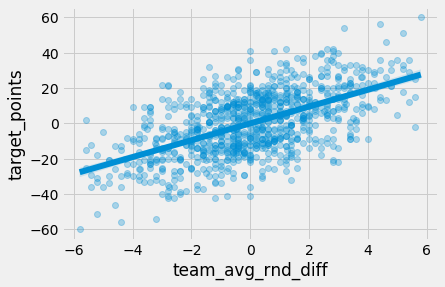

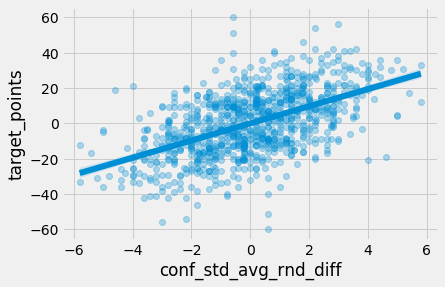

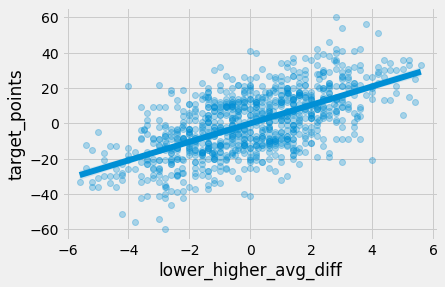

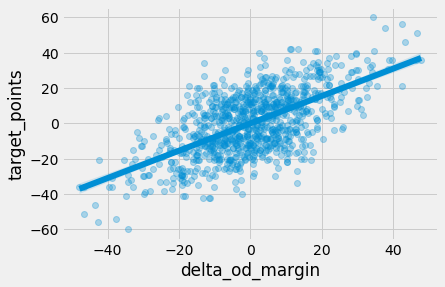

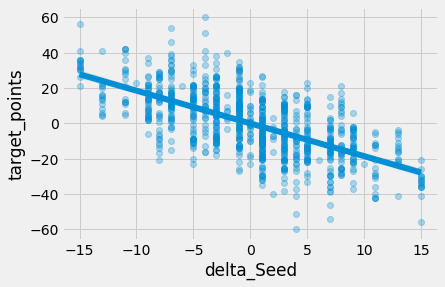

In [10]:
### Plot relationships between spread and differenced variables
## Avg. round reached by team over the prior 5 years
sns.regplot(data = tourney_results_df, x = 'team_avg_rnd_diff',
            y = 'target_points', scatter_kws={'alpha':0.3})
plt.show()

## Avg. round reached by conference/standing over the prior 5 years
sns.regplot(data = tourney_results_df, x = 'conf_std_avg_rnd_diff',
            y = 'target_points', scatter_kws={'alpha':0.3})
plt.show()

## Combination of the 2 above based on being Uconn or not
sns.regplot(data = tourney_results_df, x = 'lower_higher_avg_diff',
            y = 'target_points', scatter_kws={'alpha':0.3})
plt.show()

## Feature from Kaggle script (difference in points allowed/scored margins)
sns.regplot(data = tourney_results_df, x = 'delta_od_margin',
            y = 'target_points', scatter_kws={'alpha':0.3})
plt.show()

## Feature from Kaggle script (delta seed)
sns.regplot(data = tourney_results_df, x = 'delta_Seed',
            y = 'target_points', scatter_kws={'alpha':0.3})
plt.show()

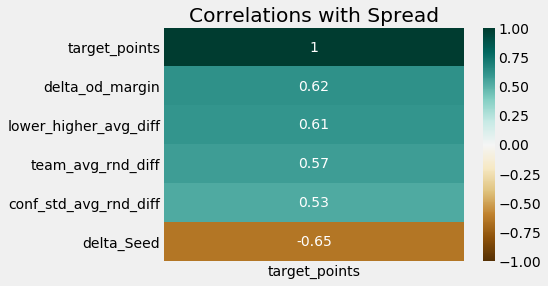

In [11]:
correlations = (tourney_results_df[['target_points', 'team_avg_rnd_diff', 'conf_std_avg_rnd_diff',
                                    'lower_higher_avg_diff', 'delta_od_margin', 'delta_Seed']]
                 .corr()[['target_points']].sort_values(by='target_points', ascending=False))

heatmap = sns.heatmap(correlations, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlations with Spread');

### Model

#### Binary outcome
Starting with logistic regression

In [12]:
train_df = tourney_results_df[tourney_results_df['Season'] < 2022].copy()


In [13]:
X = train_df[['delta_od_margin', 'lower_higher_avg_diff', 'delta_Seed']]
#X = train_df['delta_od_margin'].values.reshape(-1, 1)
clf = LogisticRegression(random_state=0, solver='lbfgs',
                          multi_class='ovr').fit(X, train_df['target'])
train_df['fitted_probabilities'] = clf.predict_proba(X)[:,1]


#### Point spread outcome
Starting with linear regression

In [14]:
reg = LinearRegression().fit(X, train_df['target_points'])

print(f"Coefficients {reg.coef_}")
print(f"R-Squared {np.round(reg.score(X, train_df['target_points']), 3)}")


Coefficients [ 0.48610187  0.64804718 -1.18023546]
R-Squared 0.554


### Submission

Manipulate the sample submission file to add predictors.



In [15]:
sample_submission = pd.read_csv("stage_2/WSampleSubmissionStage2.csv")

In [16]:
## Split out the ID
sample_submission['Season'] = sample_submission['ID'].apply(lambda x: x.split('_')[0]).astype(int)
sample_submission['Team1'] = sample_submission['ID'].apply(lambda x: x.split('_')[1]).astype(int)
sample_submission['Team2'] = sample_submission['ID'].apply(lambda x: x.split('_')[2]).astype(int)

In [17]:
### Combine custom feature(s) with reg_season_stats_df that contains all other features
conf_standings_df = conf_standings_df.rename(columns = {'Team2': 'TeamID',
                                              'T2_ConfAbbrev': 'ConfAbbrev',
                                              'T2_rank_in_conf': 'rank_in_conf',
                                              'T2_team_avg_round': 'team_avg_round',
                                              'T2_lower_higher_avg': 'lower_higher_avg'})
reg_season_stats_df = reg_season_stats_df.merge(conf_standings_df[
    ['Season', 'TeamID', 'ConfAbbrev', 'rank_in_conf', 'team_avg_round', 'lower_higher_avg']],
    on = ['Season', 'TeamID'], how = 'left')
reg_season_stats_df['lower_higher_avg'] = reg_season_stats_df['lower_higher_avg'].apply(lambda x: 0 if pd.isna(x)
                                                                                else x)

In [18]:
## Merge in the predictor variables
## For Team 1
reg_season_stats_df.columns = [c + '_1' if c[len(c)-2:] not in ['_1', '_2'] else c[:-2] + '_1' for c in reg_season_stats_df.columns]
sample_submission = sample_submission.merge(reg_season_stats_df, left_on = ['Team1', 'Season'],
                                            right_on = ['TeamID_1', 'Season_1'])
## For Team 2
reg_season_stats_df.columns = [c[:-2] + '_2' for c in reg_season_stats_df.columns]
sample_submission = sample_submission.merge(reg_season_stats_df, left_on = ['Team2', 'Season'],
                                              right_on = ['TeamID_2', 'Season_2'])
## Difference
sample_submission['od_margin_1'] = (sample_submission['off_rating_1'] - sample_submission['def_rating_1'])
sample_submission['od_margin_2'] = (sample_submission['off_rating_2'] - sample_submission['def_rating_2'])
sample_submission['delta_od_margin'] = (sample_submission['od_margin_1'] - sample_submission['od_margin_2'])
sample_submission['delta_Seed'] = (sample_submission['Seed_1'] - sample_submission['Seed_2'])
sample_submission['lower_higher_avg_diff'] = (sample_submission['lower_higher_avg_1'] - 
                                              sample_submission['lower_higher_avg_2'])

In [19]:
## Submission matrix
#X = sample_submission['delta_od_margin'].values.reshape(-1, 1)
X = sample_submission[['delta_od_margin', 'lower_higher_avg_diff', 'delta_Seed']]

## Win probability predictions
sample_submission['Pred_prob'] = clf.predict_proba(X)[:,1]

## Point spread predictions
sample_submission['Pred_spread'] = reg.predict(X)

In [21]:
(sample_submission[['ID', 'Pred_prob']].rename(columns = {'Pred_prob': 'Pred'})
   .to_csv(f"subs/submission_probs_{datetime.today().strftime('%Y-%m-%d')}.csv", index = False))

(sample_submission[['ID', 'Pred_spread']].rename(columns = {'Pred_spread': 'Pred'})
   .to_csv(f"subs/submission_spread_{datetime.today().strftime('%Y-%m-%d')}.csv", index = False))

In [22]:
(sample_submission[['ID', 'Pred_prob', 'Pred_spread']]
   .rename(columns = {'Pred_prob': 'prob',
                      'Pred_spread': 'spread'})
   .to_csv(f"subs/submission_for_table_{datetime.today().strftime('%Y-%m-%d')}.csv", index = False))